In [1]:
# Import libraries
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import os
from torch.optim import SGD
from functools import partial
import torch
import torch.nn.functional as F



In [2]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)

X_all_c, K, R, subsc, pre_imp, pre_updrs_off, per_change = util.re_index(X_all,K_all,R_all,c_cases_idx,subs,ids,all_rois,pre_imp,pre_updrs_off,post_imp)

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
['Left red nucleus' 'Left substantia nigra' 'Left subthalamic nucleus'
 'Right Substantia nigra' 'Right red nucleus' 'Right subthalamic nucleus']


In [3]:

# Lasso Regression
class LassoRegression():
    def __init__(self, learning_rate, iterations, l1_penalty):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l1_penalty = l1_penalty
 
    # Function for model training
    def fit(self, X, Y):
        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape
        # weight initialization
        self.W = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y
        # gradient descent learning
        for i in range(self.iterations):
            self.update_weights()
        return self
    
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"l1_penalty": self.l1_penalty, "learning_rate": self.learning_rate,
                "iterations": self.iterations}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Helper function to update weights in gradient descent
    def update_weights(self):
        Y_pred = self.predict(self.X)
        # calculate gradients
        dW = np.zeros(self.n)
        for j in range(self.n):
            if self.W[j] > 0:
                dW[j] = (-2 * (self.X[:, j]).dot(self.Y - Y_pred) +
                         self.l1_penalty) / self.m
            else:
                dW[j] = (-2 * (self.X[:, j]).dot(self.Y - Y_pred) -
                         self.l1_penalty) / self.m
 
        db = -2 * np.sum(self.Y - Y_pred) / self.m
 
        # update weights
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        return self
 
    # Hypothetical function h(x)
    def predict(self, X):
        return X.dot(self.W) + self.b


In [5]:
sorted(subsc)

[1.0,
 2.0,
 3.0,
 6.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 15.0,
 16.0,
 20.0,
 25.0,
 26.0,
 27.0,
 29.0,
 32.0,
 34.0,
 41.0,
 44.0,
 45.0,
 46.0,
 52.0,
 54.0,
 58.0,
 59.0,
 61.0,
 62.0,
 63.0,
 64.0,
 66.0,
 67.0,
 68.0,
 69.0,
 72.0,
 75.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 83.0,
 85.0,
 86.0,
 87.0,
 89.0,
 90.0]

In [10]:
# Training parameters
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
all_rois = False
scale_together = False
cvn = 5
alphas = np.logspace(-4,-1,10)
# Train
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,all_rois,scale_together)
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=1700)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    
    # LASSO
    lasso = slm.LassoCV(max_iter=int(1e4),n_jobs=-1,cv=cvn,alphas=alphas)
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss).item()

    lasso_sgd = LassoRegression(learning_rate=1e-3,iterations=int(1e6),l1_penalty=0)
    best_params = util.gridsearch_pickparams(lasso_sgd,cvn,{"l1_penalty":alphas},X0_ss,y_train,'r2',32)
    lasso_sgd = LassoRegression(learning_rate=1e-3,iterations=int(1e6),l1_penalty=best_params['l1_penalty'])
    est_lsg = lasso_sgd.fit(X0_ss,y_train)
    results_bls[j] = est_lsg.predict(X_test_ss)
    
    # Training status
    print('Coordinate descent predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)),
          'and',str(np.sum(est_ls.coef_!=0)),'nonzero coefficients',
          'and gradient descent predicts',str(np.round(results_bls[j],2)),
          'and',str(np.sum(est_lsg.W!=0.0)),'nonzero coefficients',
          'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Coordinate descent predicts 0.44 with regularization 0.0001 and 59 nonzero coefficients and gradient descent predicts 0.44 and 1700 nonzero coefficients for case 67 with 0.48
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Coordinate descent predicts 0.53 with regularization 0.0001 and 51 nonzero coefficients and gradient descent predicts 0.53 and 1700 nonzero coefficients for case 75 with 0.97
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Coordinate descent predicts 0.57 with regularization 0.0001 and 56 nonzero coefficients and gradient descent predicts 0.57 and 1700 nonzero coefficients for case 68 with 0.75
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Coordinate descent predicts 0.66 with regularization 0.0001 and 52 nonzero coefficients and gradient descent predicts 0.7 and 1700 nonzero coefficients for case 79 with 0.66
Fitting 5 folds for each of 10 candidates, totalling 50 f

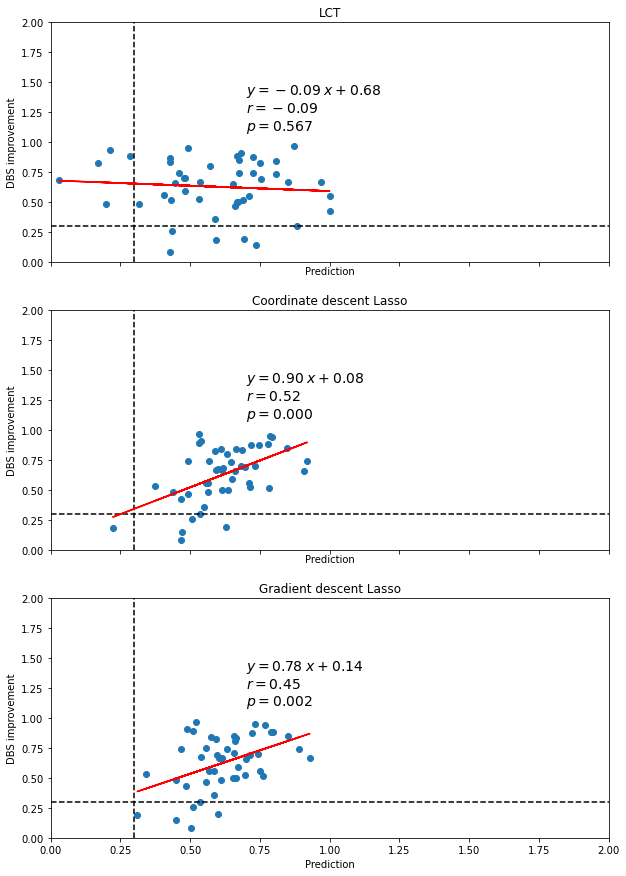

In [ ]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               results_bls,
                               )),
                               per_change,
                               ['LCT',
                                'Coordinate descent Lasso',
                                'Gradient descent Lasso'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

